<a href="https://colab.research.google.com/github/komalpachupate/Tensorflow/blob/main/Lung_xray_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash

pip install -q -U mdai

In [ ]:
import mdai
mdai.__version__

'0.7.8'

In [ ]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="3f3d7be09e9943fbcb42f6d3472e24f6")

Successfully authenticated to public.md.ai.


In [ ]:
p = mdai_client.project('aGq4k6NW', path='./lesson2-data')

Using path './lesson2-data' for data.
Preparing annotations export for project aGq4k6NW...                                                
Using cached annotations data for project aGq4k6NW.
Preparing images export for project aGq4k6NW...                                                     
Using cached images data for project aGq4k6NW.


In [ ]:
p.show_label_groups()

Label Group, Id: G_Vdj4o2, Name: Default group
	Labels:
	Id: L_A8Jm3d, Name: Lung



In [ ]:
# this maps label ids to class ids as a dict obj
labels_dict = {
    'L_A8Jm3d': 1, # Lung   
}

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_A8Jm3d': 1}


In [ ]:
p.show_datasets() 

Datasets:
Id: D_rQLwzo, Name: Dataset



In [ ]:
dataset = p.get_dataset_by_id('D_rQLwzo')
dataset.prepare()

In [ ]:
image_ids = dataset.get_image_ids()
len(image_ids)

138

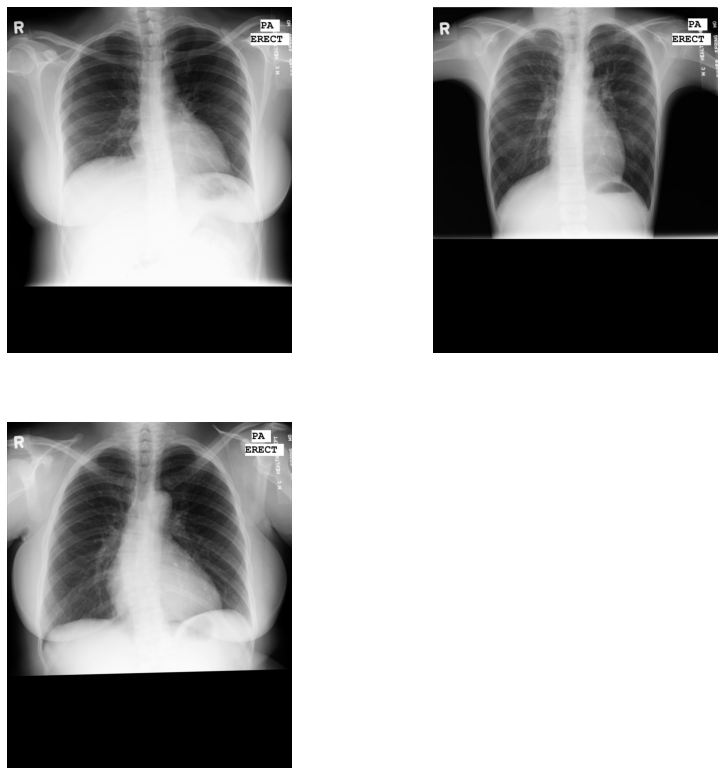

In [ ]:
# visualize a few train images 
mdai.visualize.display_images(image_ids[:3], cols=2)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
%%bash

pip install -q keras==2.3.0
pip install -q keras-unet

In [ ]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
imgs_anns_dict = dataset.imgs_anns_dict

In [ ]:
def load_images(imgs_anns_dict, img_size=128):
    images = []
    masks = []

    for img_fp in imgs_anns_dict.keys():
        img = mdai.visualize.load_dicom_image(img_fp)
        ann = imgs_anns_dict[img_fp]

        img_width = img.shape[1]
        img_height = img.shape[0]

        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        assert img.shape == mask.shape

        for a in ann:
            vertices = np.array(a['data']['vertices'])
            vertices = vertices.reshape((-1, 2))
            cv2.fillPoly(mask, np.int32([vertices]), (255, 255, 255))

        # resizing and padding
        if img.shape[0] == img.shape[1]:
            resized_shape = (img_size, img_size)
            offset = (0, 0)

        # height > width
        elif img.shape[0] > img.shape[1]:
            resized_shape = (img_size, round(img_size * img.shape[1] / img.shape[0]))
            offset = (0, (img_size - resized_shape[1]) // 2)

        else:
            resized_shape = (round(img_size * img.shape[0] / img.shape[1]), img_size)
            offset = ((img_size - resized_shape[0]) // 2, 0)

        resized_shape = (resized_shape[1], resized_shape[0])
        img_resized = cv2.resize(img, resized_shape).astype(np.uint8)
        mask_resized = cv2.resize(mask, resized_shape).astype(np.bool)

        resized_shape = (resized_shape[1], resized_shape[0])

        # add padding to square
        img_padded = np.zeros((img_size, img_size), dtype=np.uint8)
        img_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = img_resized
        mask_padded = np.zeros((img_size, img_size), dtype=np.bool)
        mask_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = mask_resized

        images.append(img_padded)
        masks.append(mask_padded)

    # add channel dim
    images = np.asarray(images)[:, :, :, None]
    masks = np.asarray(masks)[:, :, :, None]
    return images, masks

In [ ]:
images, masks = load_images(imgs_anns_dict)

120


(-0.5, 127.5, 127.5, -0.5)

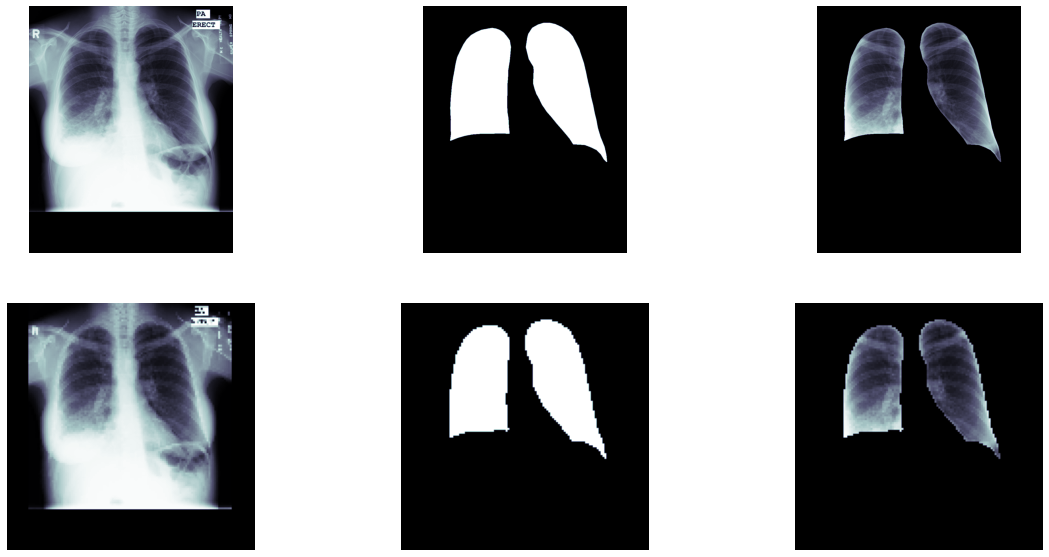

In [ ]:
img_index = random.choice(range(len(imgs_anns_dict)))

print(img_index)
img_fps = list(imgs_anns_dict.keys())
img_fp = img_fps[img_index]
img = mdai.visualize.load_dicom_image(img_fp)
ann = imgs_anns_dict[img_fp]
img_width = img.shape[1]
img_height = img.shape[0]

mask = np.zeros((img_height, img_width), dtype=np.uint8) 
for a in ann:     
    vertices = np.array(a['data']['vertices'])
    vertices = vertices.reshape((-1,2))                     
    cv2.fillPoly(mask, np.int32([vertices]), (255,255,255))
    
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.imshow(img, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,3)              
plt.imshow(cv2.bitwise_and(img, img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(images[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(masks[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(cv2.bitwise_and(images[img_index,:,:,0], images[img_index,:,:,0], 
                           mask=masks[img_index,:,:,0].astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=0)

In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
    ))

In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    x_train[0].shape,
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min')

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
#history = model.fit_generator(
 #   train_gen,
  #  steps_per_epoch=100,
   # epochs=10,
    #validation_data=(x_val, y_val))

In [ ]:
history = model.fit(x_train,y_train,epochs=10,batch_size=10)

Epoch 1/10
11/11 [==============================] - 133s 12s/step - loss: 0.3841 - accuracy: 0.8482
Epoch 2/10
11/11 [==============================] - 131s 12s/step - loss: 0.1499 - accuracy: 0.9626
Epoch 3/10
11/11 [==============================] - 131s 12s/step - loss: 0.1045 - accuracy: 0.9727
Epoch 4/10
11/11 [==============================] - 131s 12s/step - loss: 0.0865 - accuracy: 0.9768
Epoch 5/10
11/11 [==============================] - 131s 12s/step - loss: 0.0726 - accuracy: 0.9794
Epoch 6/10
11/11 [==============================] - 130s 12s/step - loss: 0.0649 - accuracy: 0.9814
Epoch 7/10
11/11 [==============================] - 130s 12s/step - loss: 0.0549 - accuracy: 0.9838
Epoch 8/10
11/11 [==============================] - 131s 12s/step - loss: 0.0476 - accuracy: 0.9855
Epoch 9/10
11/11 [==============================] - 130s 12s/step - loss: 0.0430 - accuracy: 0.9865
Epoch 10/10
11/11 [==============================] - 131s 12s/step - loss: 0.0417 - accuracy: 0.9864

dict_keys(['loss', 'accuracy'])


KeyError: ignored

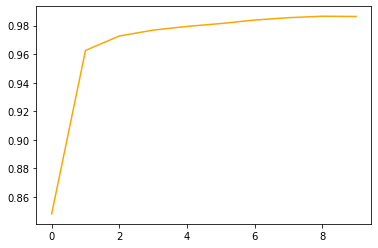

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Predicted Lung Segmentation')

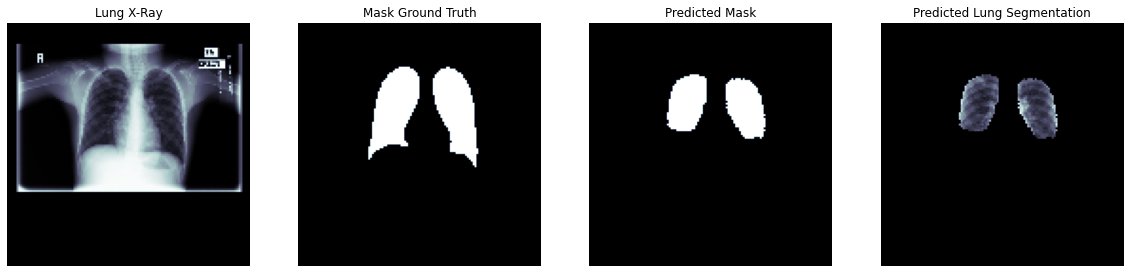

In [ ]:
images, masks = load_images(imgs_anns_dict)

plt.figure(figsize=(20, 10))

img_index = random.choice(range(len(images)))

plt.subplot(1,4,1)
random_img = images[img_index,:,:,0]
plt.imshow(random_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Lung X-Ray')

plt.subplot(1,4,2)
random_mask = masks[img_index,:,:,0]
plt.imshow(random_mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Mask Ground Truth')

random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
mask = model.predict(random_img_2)[0][:,:,0] > 0.5
plt.subplot(1,4,3)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1,4,4)
plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')